<a href="https://colab.research.google.com/github/Nancy-Shi/Individual_Infection_Network/blob/main/1205_1000_ER_regular_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Compare ER network and regular network**

In this part of the project, we create a tool to achieve the following:
1. Our input is an N by N matrix representing a social network with N nodes with 1 or 0 representing the presence or absence of edges.
2. We then construct a graph from the given matrix.
3. Based on the network, we apply the equations for individual infection risk, derive the corresponding equations, and compute a table of probability with infection starting at different nodes.
4. Finally, we take the average infection probability of each node, excluding the case when it is the seed.
5. Depending on the average infection probabilty, we color the network graph with a heatmap color scheme, such that red is the highest infection risk and blue/purple is the lowest infection risk.
6. Our output include: a probability table, a table including all the average infection probability, and a heatmap network for individual infection probability/risk.

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import random
import numpy as np
import pandas as pd
import os
import sympy as sp
from sklearn.metrics import r2_score, mean_squared_error
from scipy.optimize import curve_fit
import math

In [ ]:
def generate_er_network(N, k):
    p = k / (N - 1)          # ensure avg degree ≈ k
    adj_matrix = [[0]*N for _ in range(N)]
    for i in range(N):
        for j in range(i+1, N):
            if random.random() < p:
                adj_matrix[i][j] = 1
                adj_matrix[j][i] = 1
    return adj_matrix

def generate_k_regular_network(N, k):
    adj_matrix = [[0]*N for _ in range(N)]

    stubs = []
    for i in range(N):
        stubs.extend([i]*k)

    random.shuffle(stubs)

    while len(stubs) >= 2:
        a = stubs.pop()
        b = stubs.pop()

        if a == b or adj_matrix[a][b] == 1:
            stubs.extend([a, b])
            random.shuffle(stubs)
            continue

        adj_matrix[a][b] = 1
        adj_matrix[b][a] = 1

    return adj_matrix


In [ ]:
# Function to generate a network from an N by N adjacency matrix.
def generate_network(adj_matrix):
    G = nx.Graph()
    N = len(adj_matrix)
    G.add_nodes_from(range(N))
    for i in range(N):
        for j in range(i+1, N):   # avoid duplicates and self-loops
            if adj_matrix[i][j] == 1:
                G.add_edge(i, j)
    return G

In [ ]:
def preprocess_neighbors(G):
    nodes = list(G.nodes())
    node_index = {v: i for i, v in enumerate(nodes)}
    neighbors_idx = []

    for v in nodes:
        neighs = list(G.neighbors(v))
        neighbors_idx.append(np.array([node_index[u] for u in neighs], dtype=int))

    return nodes, node_index, neighbors_idx

In [ ]:
def fixed_point_solver_message_passing(neighbors_idx, seed_index, p_val, tol=1e-6, max_iter=5000, relax=0.3):

    n = len(neighbors_idx)

    edge_to_idx = {}
    idx_to_edge = []

    for i in range(n):
        for j in neighbors_idx[i]:
            edge_to_idx[(j, i)] = len(idx_to_edge)
            idx_to_edge.append((j, i))

    m = len(idx_to_edge)

    # Messages theta_{j->i}: probability that j does NOT infect i
    theta = np.ones(m, dtype=float)

    for _ in range(max_iter):
        theta_new = theta.copy()

        for e_idx, (j, i) in enumerate(idx_to_edge):
            if j == seed_index:
                theta_new[e_idx] = 1.0 - p_val
                continue

            neigh_j = neighbors_idx[j]

            # Compute u_{j->i} = product over k in N(j)\{i} of theta_{k->j}
            if len(neigh_j) == 0:
                u = 1.0
            else:
                prod = 1.0
                for k in neigh_j:
                    if k == i:
                        continue
                    prod *= theta[edge_to_idx[(k, j)]]
                u = prod

            theta_new[e_idx] = 1.0 - p_val + p_val * u

        theta_updated = (1.0 - relax) * theta + relax * theta_new

        if np.max(np.abs(theta_updated - theta)) < tol:
            theta = theta_updated
            break

        theta = theta_updated

    sigma = np.zeros(n, dtype=float)

    for i in range(n):
        if i == seed_index:
            sigma[i] = 1.0
            continue

        neigh_i = neighbors_idx[i]
        if len(neigh_i) == 0:
            sigma[i] = 0.0
            continue

        prod = 1.0
        for j in neigh_i:
            prod *= theta[edge_to_idx[(j, i)]]
        sigma[i] = 1.0 - prod

    return sigma

In [ ]:
from joblib import Parallel, delayed

def compute_attack_matrix(G, p_val, n_jobs=-1):
    nodes, node_index, neighbors_idx = preprocess_neighbors(G)
    n = len(nodes)

    sigmas = Parallel(n_jobs=n_jobs)(
        delayed(fixed_point_solver_message_passing)(neighbors_idx, seed_index=node_index[s], p_val=p_val)
        for s in nodes
    )

    mat = np.array(sigmas).T

    return nodes, mat


def save_attack_csv(nodes, mat, p_val, label, outdir="/content/drive/My Drive/Individual_Attack_Rate"):
    os.makedirs(outdir, exist_ok=True)
    df = pd.DataFrame(
        mat,
        index=[f"sigma_{i}" for i in nodes],
        columns=[f"Seed {i}" for i in nodes]
    )
    path = os.path.join(outdir, f"individual_attack_{label}.csv")
    df.to_csv(path, float_format="%.6f")
    return path, df

In [ ]:
# Function to compute the average infection rate by taking the average of the matrix for each row, excluding the 1 value (seed node case)
def compute_average_attack(nodes, mat):
    mat_no_diag = mat.copy()
    np.fill_diagonal(mat_no_diag, np.nan)
    return np.nanmean(mat_no_diag, axis=1)

def save_average_attack_csv(nodes, avg_attack, p_val, outdir="/content/drive/My Drive/Individual_Attack_Rate"):
    os.makedirs(outdir, exist_ok=True)

    df = pd.DataFrame({
        "Node": nodes,
        "AverageAttackRate": avg_attack
    })

    path = os.path.join(outdir, f"average_ER_regular_p{p_val:.3f}.csv")
    df.to_csv(path, index=False, float_format="%.6f")

    return path, df


In [ ]:
# Function to visualize the network based on the node index, color the nodes based on a heatmap scale using their average attack rate
def visualize_attack_network_comparison(
    G_ER, nodes_ER, avg_ER,
    G_reg, nodes_reg, avg_reg,
    cmap_name="jet",
    out_path=None
):
    avg_ER  = np.asarray(avg_ER, dtype=float)
    avg_reg = np.asarray(avg_reg, dtype=float)

    all_vals = np.concatenate([avg_ER, avg_reg])
    vmin = float(np.nanmin(all_vals))
    vmax = float(np.nanmax(all_vals))

    fig, axes = plt.subplots(1, 2, figsize=(22, 12))

    def draw_panel(ax, G, nodes, avg_attack, panel_label, vmin, vmax):
        nodes = list(nodes)
        avg_attack = np.asarray(avg_attack, dtype=float)
        attack_dict = {node: avg_attack[i] for i, node in enumerate(nodes)}

        pos = nx.spring_layout(G, seed=42, k=0.25, iterations=300)
        node_colors = [attack_dict[n] for n in G.nodes()]

        nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.8, width=1.0, edge_color="gray")
        nodes_draw = nx.draw_networkx_nodes(
            G, pos, ax=ax,
            node_color=node_colors,
            cmap=plt.get_cmap(cmap_name),
            node_size=40,
            linewidths=0.4,
            edgecolors="black",
            vmin=vmin, vmax=vmax
        )

        ax.set_axis_off()
        ax.text(
            0.03, 0.97, panel_label,
            transform=ax.transAxes,
            ha="left", va="top",
            fontsize=22, fontweight="bold"
        )
        return nodes_draw

    nodes_draw = draw_panel(axes[0], G_ER,  nodes_ER,  avg_ER,  panel_label="A", vmin=vmin, vmax=vmax)
    draw_panel(axes[1],       G_reg, nodes_reg, avg_reg, panel_label="B", vmin=vmin, vmax=vmax)

    fig.tight_layout(rect=[0.03, 0.10, 0.97, 1.0])

    cbar_ax = fig.add_axes([0.20, 0.04, 0.60, 0.02])
    cbar = fig.colorbar(nodes_draw, cax=cbar_ax, orientation="horizontal")
    cbar.set_label("Average individual infection probability", fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    if out_path is not None:
        plt.savefig(out_path, dpi=1200, bbox_inches="tight")
    plt.show()

In [ ]:
def save_graph_neighbor_csv(G, filename, outdir="/content/drive/My Drive/Individual_Attack_Rate"):
    os.makedirs(outdir, exist_ok=True)
    path = os.path.join(outdir, filename)

    nodes = sorted(G.nodes())
    index_map = {v: i for i, v in enumerate(nodes)}

    data = []
    for v in nodes:
        neigh_indices = [index_map[u] for u in G.neighbors(v)]
        neigh_str = ",".join(str(n) for n in neigh_indices)
        degree = len(neigh_indices)
        data.append([index_map[v], neigh_str, degree])

    df = pd.DataFrame(data, columns=["node", "neighbors", "degree"])
    df.to_csv(path, index=False)

    return path, df

In [ ]:
import pandas as pd
import os

def rank_nodes_by_attack(csv_path, outdir="/content/drive/My Drive/Individual_Attack_Rate"):
    df = pd.read_csv(csv_path)

    df_ranked = df.sort_values(by="AverageAttackRate", ascending=False).reset_index(drop=True)

    df_ranked["Rank"] = df_ranked.index + 1

    os.makedirs(outdir, exist_ok=True)
    out_path = os.path.join(outdir, "ranked_ER_regular_" + os.path.basename(csv_path))
    df_ranked.to_csv(out_path, index=False, float_format="%.6f")

    print("\nRanked results:\n")
    print(df_ranked.head())

    return out_path, df_ranked

In [ ]:
def plot_ranked_histogram_two_panel(
    ranked_csv_path_ER,
    ranked_csv_path_reg,
    outdir,
    fig_name
):
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import os

    def build_hist(ax, ranked_csv, panel_label):
        df = pd.read_csv(ranked_csv)
        vals = df["AverageAttackRate"].values
        vals = vals[~np.isnan(vals)]

        plt.style.use("seaborn-v0_8-white")

        main_bins = np.arange(0, 0.08, 0.01)
        hist_bins = np.arange(0, 0.08 + 0.001, 0.005)
        colors = plt.cm.rainbow(np.linspace(0, 1, len(main_bins)-1))

        for i in range(len(main_bins)-1):
            lo, hi = main_bins[i], main_bins[i+1]
            mask = (vals >= lo) & (vals < hi)

            ax.hist(
                vals[mask],
                bins=hist_bins,
                alpha=0.85,
                color=colors[i],
                edgecolor="white",
                linewidth=0.4
            )

        ax.set_xlabel("Individual Infection Probability", fontsize=10)
        ax.set_ylabel("Density", fontsize=10)

        ax.set_xlim(0,0.08)

        ax.text(
            0.03, 0.97, panel_label,
            transform=ax.transAxes,
            ha="left", va="top",
            fontsize=14, fontweight="bold"
        )

        ax.tick_params(labelsize=8)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_linewidth(1.2)
        ax.spines["bottom"].set_linewidth(1.2)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=300)

    build_hist(axes[0], ranked_csv_path_ER, panel_label="A")
    build_hist(axes[1], ranked_csv_path_reg, panel_label="B")

    plt.tight_layout()

    fig_path = os.path.join(outdir, fig_name)
    plt.savefig(fig_path, bbox_inches="tight", dpi=300)
    plt.show()


In [ ]:
def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

def plot_saturating(ax, x_raw, y, xlabel, panel_label, color):
    x_scaled = x_raw.values * 1e3
    x = x_scaled
    p0 = [1.0, 1.0, np.median(x)]
    params, _ = curve_fit(logistic, x, y, p0=p0, maxfev=20000)
    L, k, x0 = params
    y_pred = logistic(x, L, k, x0)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    order = np.argsort(x)
    xs = x[order]
    ys = y[order]
    yfit = y_pred[order]
    ax.scatter(xs, ys, s=12, alpha=0.7, color=color, edgecolor="none")
    ax.plot(xs, yfit, lw=2.2, color=color)
    ax.set_xlabel(f"{xlabel} ($\\times 10^{{-3}}$)")
    ax.set_ylabel("Infection Probability")
    ax.text(0.03, 0.97, panel_label, transform=ax.transAxes,
            ha="left", va="top", fontsize=14, fontweight="bold")
    ax.text(0.97, 0.85,
            f"$R^2 = {r2:.3f}$\nRMSE = {rmse:.3f}",
            transform=ax.transAxes, ha="right", va="bottom",
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.6", alpha=0.9))
    formula = r"$y = \frac{{{:.3f}}}{{1 + \exp[-{:.3f}(x - {:.3f})]}}$".format(L, k, x0)
    ax.text(0.25, 0.20, formula, transform=ax.transAxes,
            fontsize=10, ha="left", va="bottom",
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.6", alpha=0.85))
    ax.tick_params(direction="in", top=True, right=True)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.35)
    ax.set_xlim(left=0)
    ax.set_ylim(0, 0.08)
    return (L, k, x0, r2, rmse)

def make_centrality_figure(
    neighbors_path_ER,
    ranked_path_ER,
    neighbors_path_reg,
    ranked_path_reg,
    outdir,
    merged_basename_ER,
    merged_basename_reg,
    fig_basename
):
    df_neighbors_ER = pd.read_csv(neighbors_path_ER)
    df_ranked_ER = pd.read_csv(ranked_path_ER)

    G_ER = nx.Graph()
    for _, row in df_neighbors_ER.iterrows():
        i = int(row["node"])
        neighs = [int(x) for x in str(row["neighbors"]).split(",") if str(x).strip() != ""]
        for j in neighs:
            G_ER.add_edge(i, j)

    deg_cent_ER = nx.degree_centrality(G_ER)
    bet_cent_ER = nx.betweenness_centrality(G_ER, normalized=True)

    centrality_ER = pd.DataFrame({
        "node": list(deg_cent_ER.keys()),
        "degree_centrality": [deg_cent_ER[n] for n in deg_cent_ER],
        "betweenness_centrality": [bet_cent_ER[n] for n in deg_cent_ER],
    })

    df_ranked_ER = df_ranked_ER.copy()
    df_ranked_ER["node"] = df_ranked_ER["Node"]
    merged_ER = df_ranked_ER.merge(centrality_ER, on="node", how="left").drop(columns=["node"])
    merged_path_ER = os.path.join(outdir, merged_basename_ER)
    merged_ER.to_csv(merged_path_ER, index=False)

    df_neighbors_reg = pd.read_csv(neighbors_path_reg)
    df_ranked_reg = pd.read_csv(ranked_path_reg)

    G_reg = nx.Graph()
    for _, row in df_neighbors_reg.iterrows():
        i = int(row["node"])
        neighs = [int(x) for x in str(row["neighbors"]).split(",") if str(x).strip() != ""]
        for j in neighs:
            G_reg.add_edge(i, j)

    deg_cent_reg = nx.degree_centrality(G_reg)
    bet_cent_reg = nx.betweenness_centrality(G_reg, normalized=True)

    centrality_reg = pd.DataFrame({
        "node": list(deg_cent_reg.keys()),
        "degree_centrality": [deg_cent_reg[n] for n in deg_cent_reg],
        "betweenness_centrality": [bet_cent_reg[n] for n in deg_cent_reg],
    })

    df_ranked_reg = df_ranked_reg.copy()
    df_ranked_reg["node"] = df_ranked_reg["Node"]
    merged_reg = df_ranked_reg.merge(centrality_reg, on="node", how="left").drop(columns=["node"])
    merged_path_reg = os.path.join(outdir, merged_basename_reg)
    merged_reg.to_csv(merged_path_reg, index=False)

    y_ER = merged_ER["AverageAttackRate"].values
    y_reg = merged_reg["AverageAttackRate"].values

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    plot_saturating(
        axes[0, 0], merged_ER["degree_centrality"], y_ER,
        xlabel="Degree centrality (ER)", panel_label="A", color="#1f77b4"
    )

    plot_saturating(
        axes[0, 1], merged_ER["betweenness_centrality"], y_ER,
        xlabel="Betweenness centrality (ER)", panel_label="B", color="#6a3d9a"
    )

    plot_saturating(
        axes[1, 0], merged_reg["degree_centrality"], y_reg,
        xlabel="Degree centrality (regular)", panel_label="C", color="#1f77b4"
    )

    plot_saturating(
        axes[1, 1], merged_reg["betweenness_centrality"], y_reg,
        xlabel="Betweenness centrality (regular)", panel_label="D", color="#6a3d9a"
    )

    for ax in axes.flat:
        ax.set_xlim(left=0)
        ax.set_ylim(0, 0.08)
        ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.35)

    fig.tight_layout()
    fig_path = os.path.join(outdir, fig_basename)
    plt.savefig(fig_path, dpi=600, bbox_inches="tight")
    plt.show()

    return merged_path_ER, merged_path_reg



Ranked results:

   Node  AverageAttackRate  Rank
0   818           0.068387     1
1   206           0.066432     2
2   333           0.061544     3
3    33           0.060612     4
4   639           0.060510     5

Ranked results:

   Node  AverageAttackRate  Rank
0    79            0.00928     1
1    94            0.00928     2
2   862            0.00928     3
3   243            0.00928     4
4   593            0.00928     5


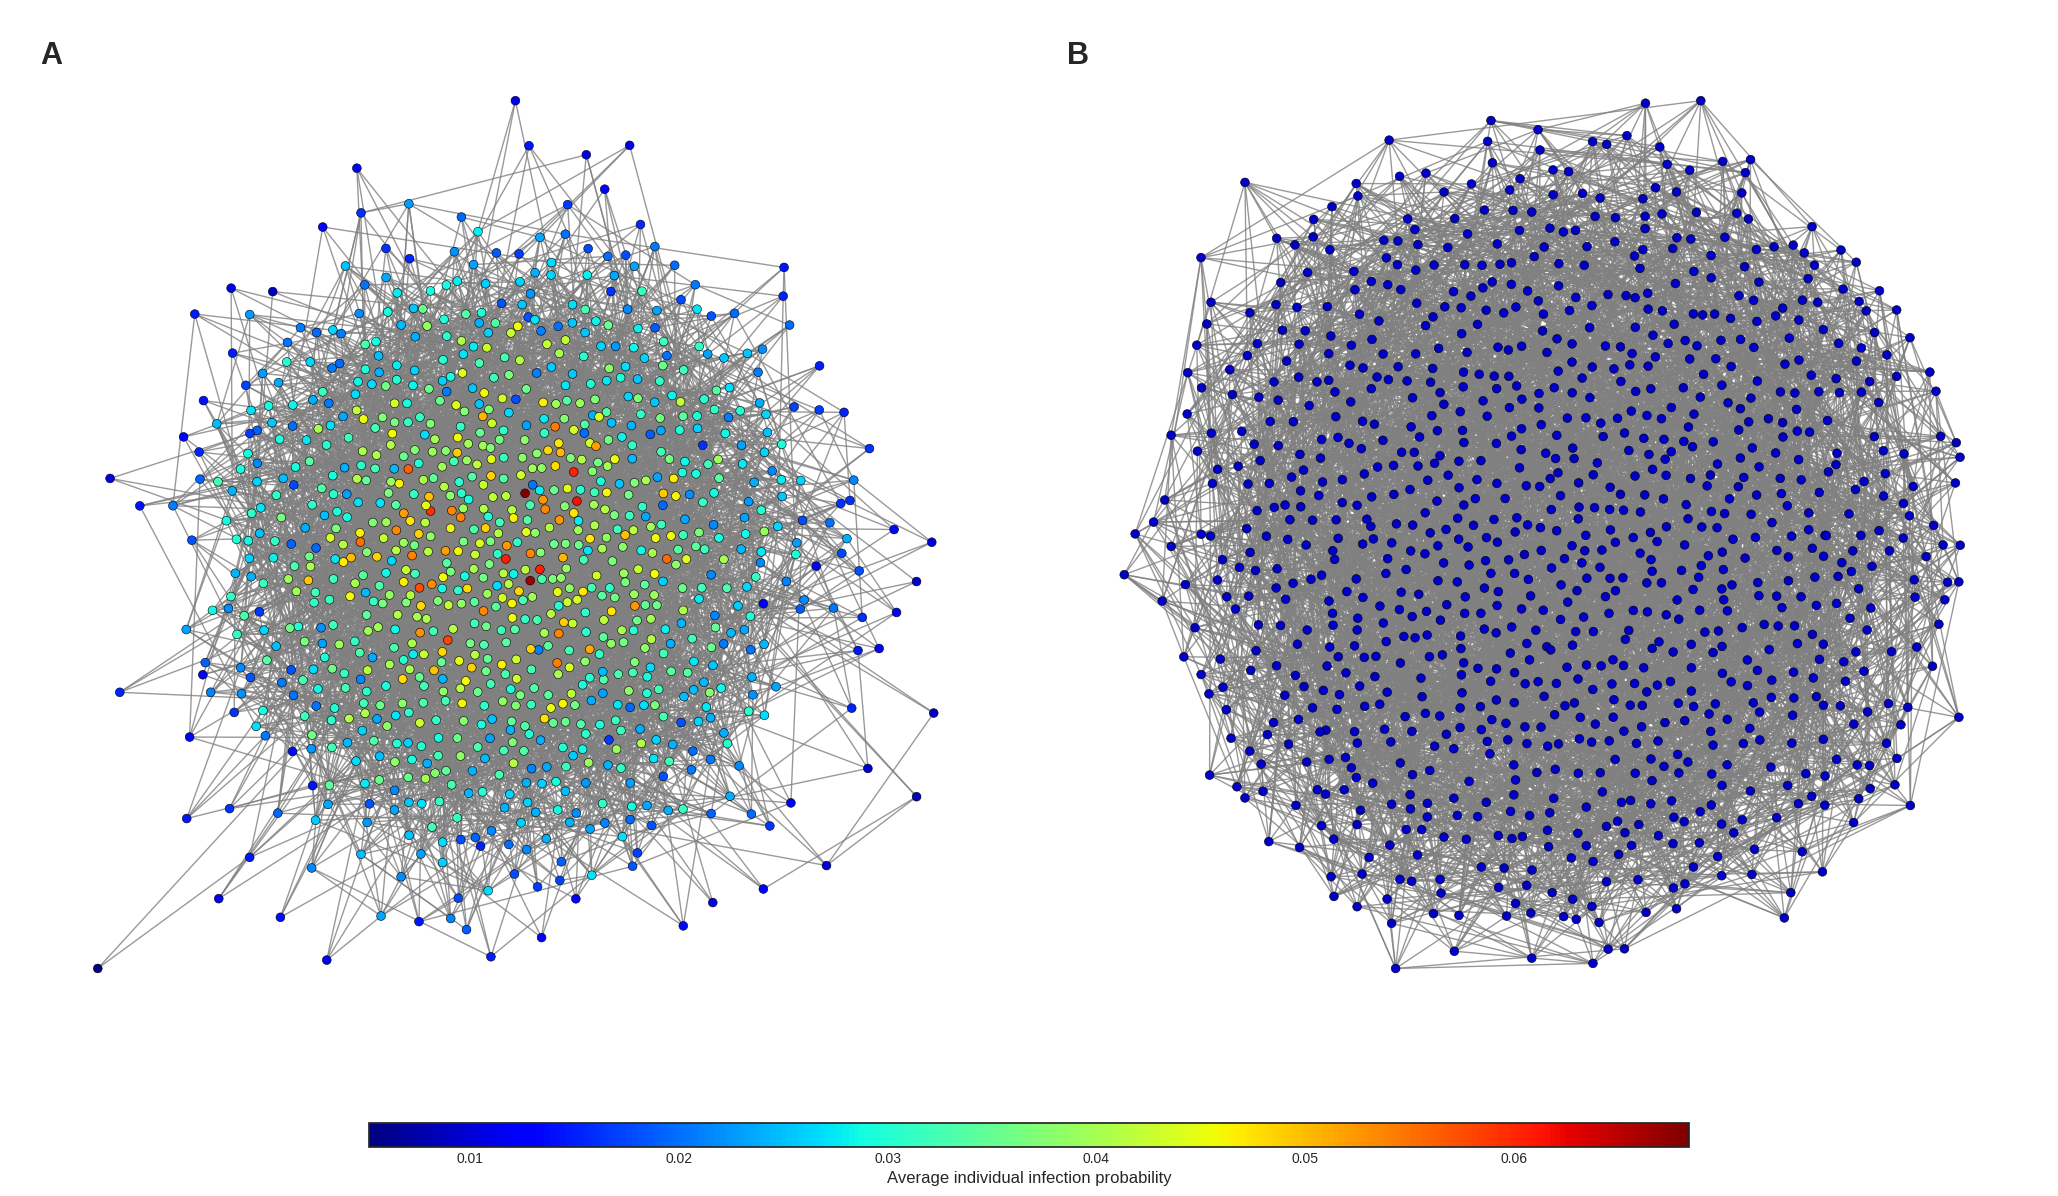

In [ ]:
N = 1000
k = 10
p_val = 0.1

adj_ER  = generate_er_network(N, k)
adj_reg = generate_k_regular_network(N, k)

outdir = "/content/drive/My Drive/Individual_Attack_Rate"

cases = [("ER", adj_ER), ("regular", adj_reg)]

G_ER = None
nodes_ER = None
avg_attack_ER = None
neighbors_ER_path = None
ranked_ER_path = None

G_reg = None
nodes_reg = None
avg_attack_reg = None
neighbors_reg_path = None
ranked_reg_path = None

for label, adj_matrix in cases:
    G = generate_network(adj_matrix)

    with open(f"{outdir}/graph_{label}.pkl", "wb") as f:
        pickle.dump(G, f)

    np.savetxt(
        f"{outdir}/adj_matrix_{label}.csv",
        np.array(adj_matrix, dtype=int),
        fmt="%d",
        delimiter=","
    )

    neigh_filename = f"graph_neighbors_{label}.csv"
    neigh_path, df_neigh = save_graph_neighbor_csv(G, neigh_filename, outdir=outdir)

    nodes, attack_mat = compute_attack_matrix(G, p_val)

    indiv_path, df_indiv = save_attack_csv(
        nodes, attack_mat, p_val, label, outdir=outdir
    )

    avg_attack = compute_average_attack(nodes, attack_mat)

    avg_path, df_avg = save_average_attack_csv(
        nodes, avg_attack, p_val, outdir=outdir
    )
    labeled_avg_path = os.path.join(
        outdir, f"average_attack_{label}.csv"
    )
    os.rename(avg_path, labeled_avg_path)

    ranked_path, df_ranked = rank_nodes_by_attack(
        labeled_avg_path,
        outdir=outdir
    )
    labeled_ranked_path = os.path.join(
        outdir, f"ranked_attack_{label}.csv"
    )
    os.rename(ranked_path, labeled_ranked_path)

    if label == "ER":
        G_ER = G
        nodes_ER = nodes
        avg_attack_ER = avg_attack
        neighbors_ER_path = neigh_path
        ranked_ER_path = labeled_ranked_path
    elif label == "regular":
        G_reg = G
        nodes_reg = nodes
        avg_attack_reg = avg_attack
        neighbors_reg_path = neigh_path
        ranked_reg_path = labeled_ranked_path

visualize_attack_network_comparison(
    G_ER, nodes_ER, avg_attack_ER,
    G_reg, nodes_reg, avg_attack_reg,
    cmap_name="jet",
    out_path=os.path.join(outdir, f"network_compare_ER_regular.pdf")
)




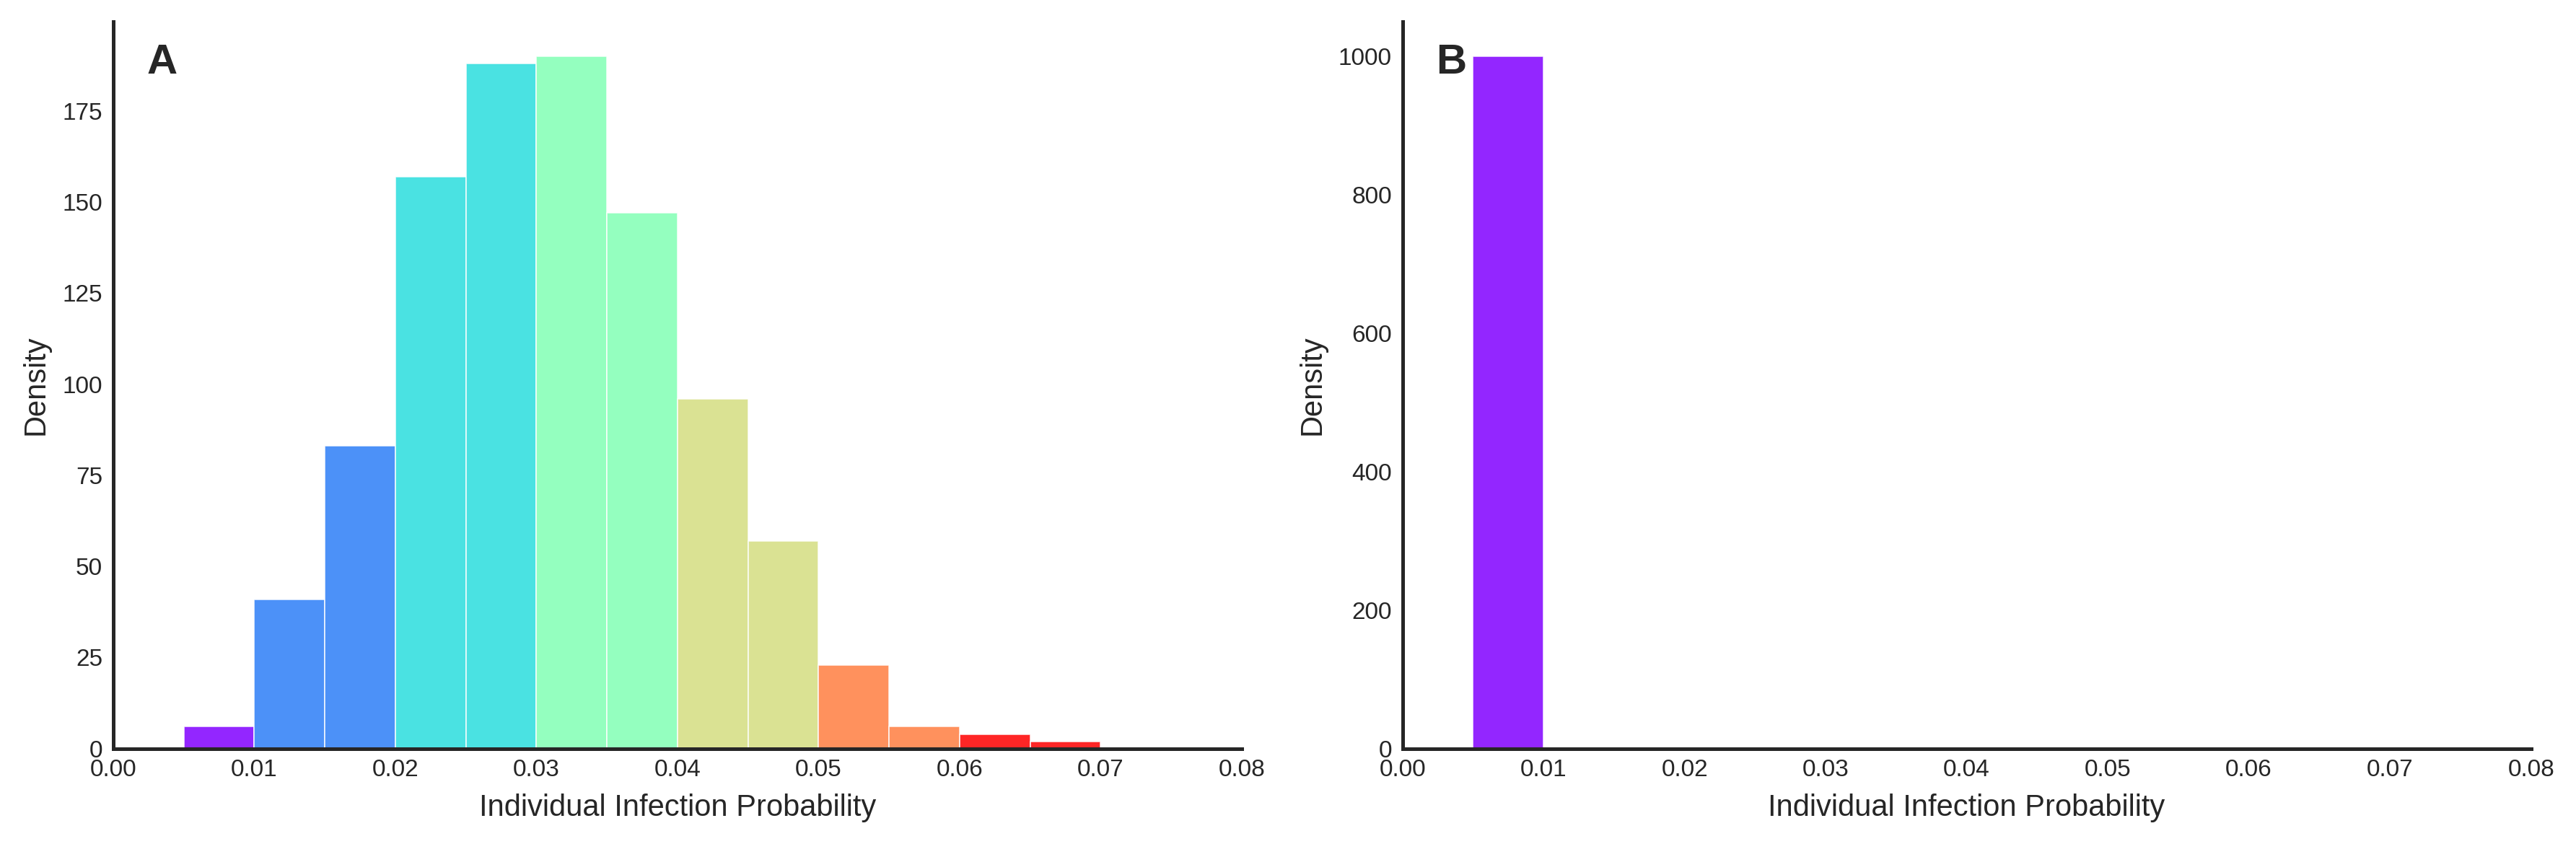

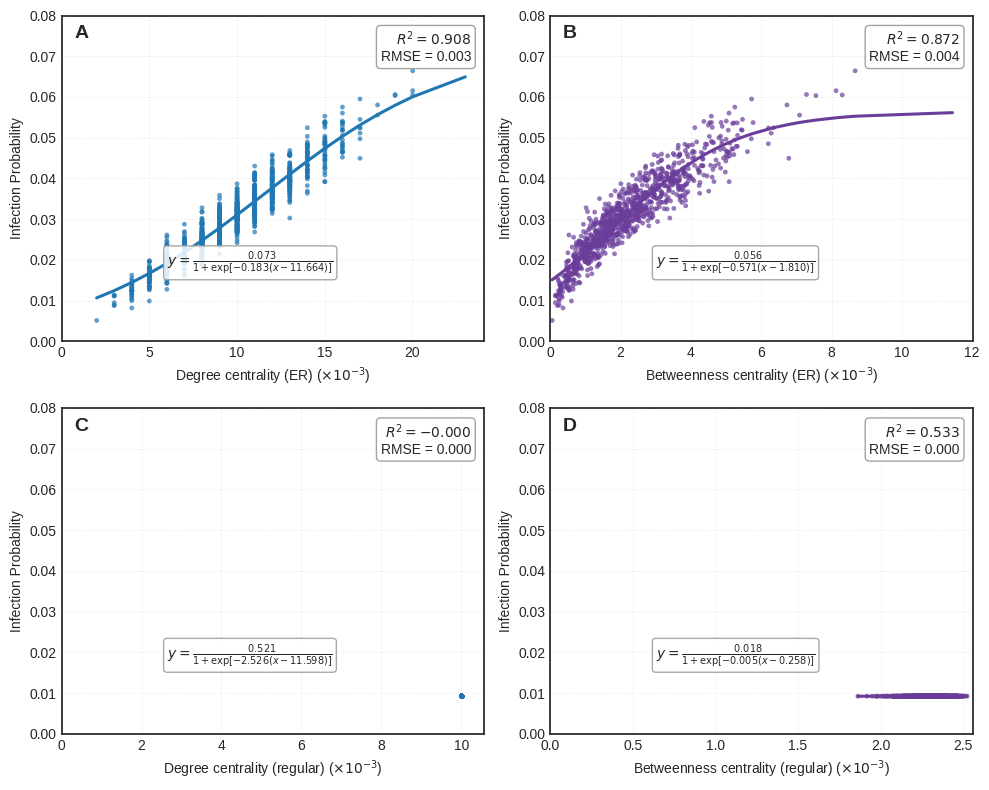

('/content/drive/My Drive/Individual_Attack_Rate/ranked_with_centrality_ER.csv',
 '/content/drive/My Drive/Individual_Attack_Rate/ranked_with_centrality_regular.csv')

In [ ]:
# do the pairwise comparisons (after loop)

plot_ranked_histogram_two_panel(
    ranked_csv_path_ER=ranked_ER_path,
    ranked_csv_path_reg=ranked_reg_path,
    outdir=outdir,
    fig_name=f"hist_ranked_attack_compare_ER_regular.pdf"
)

make_centrality_figure(
    neighbors_path_ER=neighbors_ER_path,
    ranked_path_ER=ranked_ER_path,
    neighbors_path_reg=neighbors_reg_path,
    ranked_path_reg=ranked_reg_path,
    outdir=outdir,
    merged_basename_ER=f"ranked_with_centrality_ER.csv",
    merged_basename_reg=f"ranked_with_centrality_regular.csv",
    fig_basename=f"centrality_ER_vs_regular.pdf"
)

In [ ]:
# Histogram for distribution of probability for a node of a certain degree
def plot_prob_histograms_by_degree(individual_csv,
                                   neighbors_csv,
                                   bins=np.linspace(0, 1, 21),
                                   max_cols=6,
                                   save_pdf=True,
                                   outname="histograms_by_degree.pdf"):

    df_indiv = pd.read_csv(individual_csv)
    df_deg   = pd.read_csv(neighbors_csv)

    prob_cols = [c for c in df_indiv.columns if c.startswith("Seed ")]
    probs = df_indiv[prob_cols].to_numpy()

    np.fill_diagonal(probs, np.nan)

    N = probs.shape[0]
    deg_series = df_deg.set_index("node")["degree"].reindex(np.arange(N))

    unique_degrees = np.sort(deg_series.unique())
    n_deg = len(unique_degrees)

    n_cols = min(max_cols, n_deg)
    n_rows = math.ceil(n_deg / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(4 * n_cols, 3.2 * n_rows),
                             sharex=True, sharey=True)

    if n_deg == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for idx, k in enumerate(unique_degrees):
        ax = axes[idx]
        nodes_k = np.where(deg_series.values == k)[0]
        data_k = probs[nodes_k, :].ravel() # get all the probabilities for these rows
        data_k = data_k[~np.isnan(data_k)]

        if len(data_k) > 0:
            weights = np.ones_like(data_k) * 100.0 / len(data_k)
            ax.hist(data_k, bins=bins, weights=weights, edgecolor="black")

        ax.set_title(f"Degree k={k} (n={len(nodes_k)})")

        row = idx // n_cols
        col = idx % n_cols

        if row == n_rows - 1:
            ax.set_xlabel("Probability")
        else:
            ax.set_xlabel("")

        if col == 0:
            ax.set_ylabel("Frequency (%)")
        else:
            ax.set_ylabel("")

    for j in range(n_deg, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

    if save_pdf:
        outdir = os.path.dirname(individual_csv)
        outfile = os.path.join(outdir, outname)
        plt.savefig(outfile, format="pdf", dpi=300, bbox_inches="tight")
        print("Saved PDF to:", outfile)

    plt.show()

Saved PDF to: /content/drive/My Drive/Individual_Attack_Rate/degree_hist_panels_ER.pdf


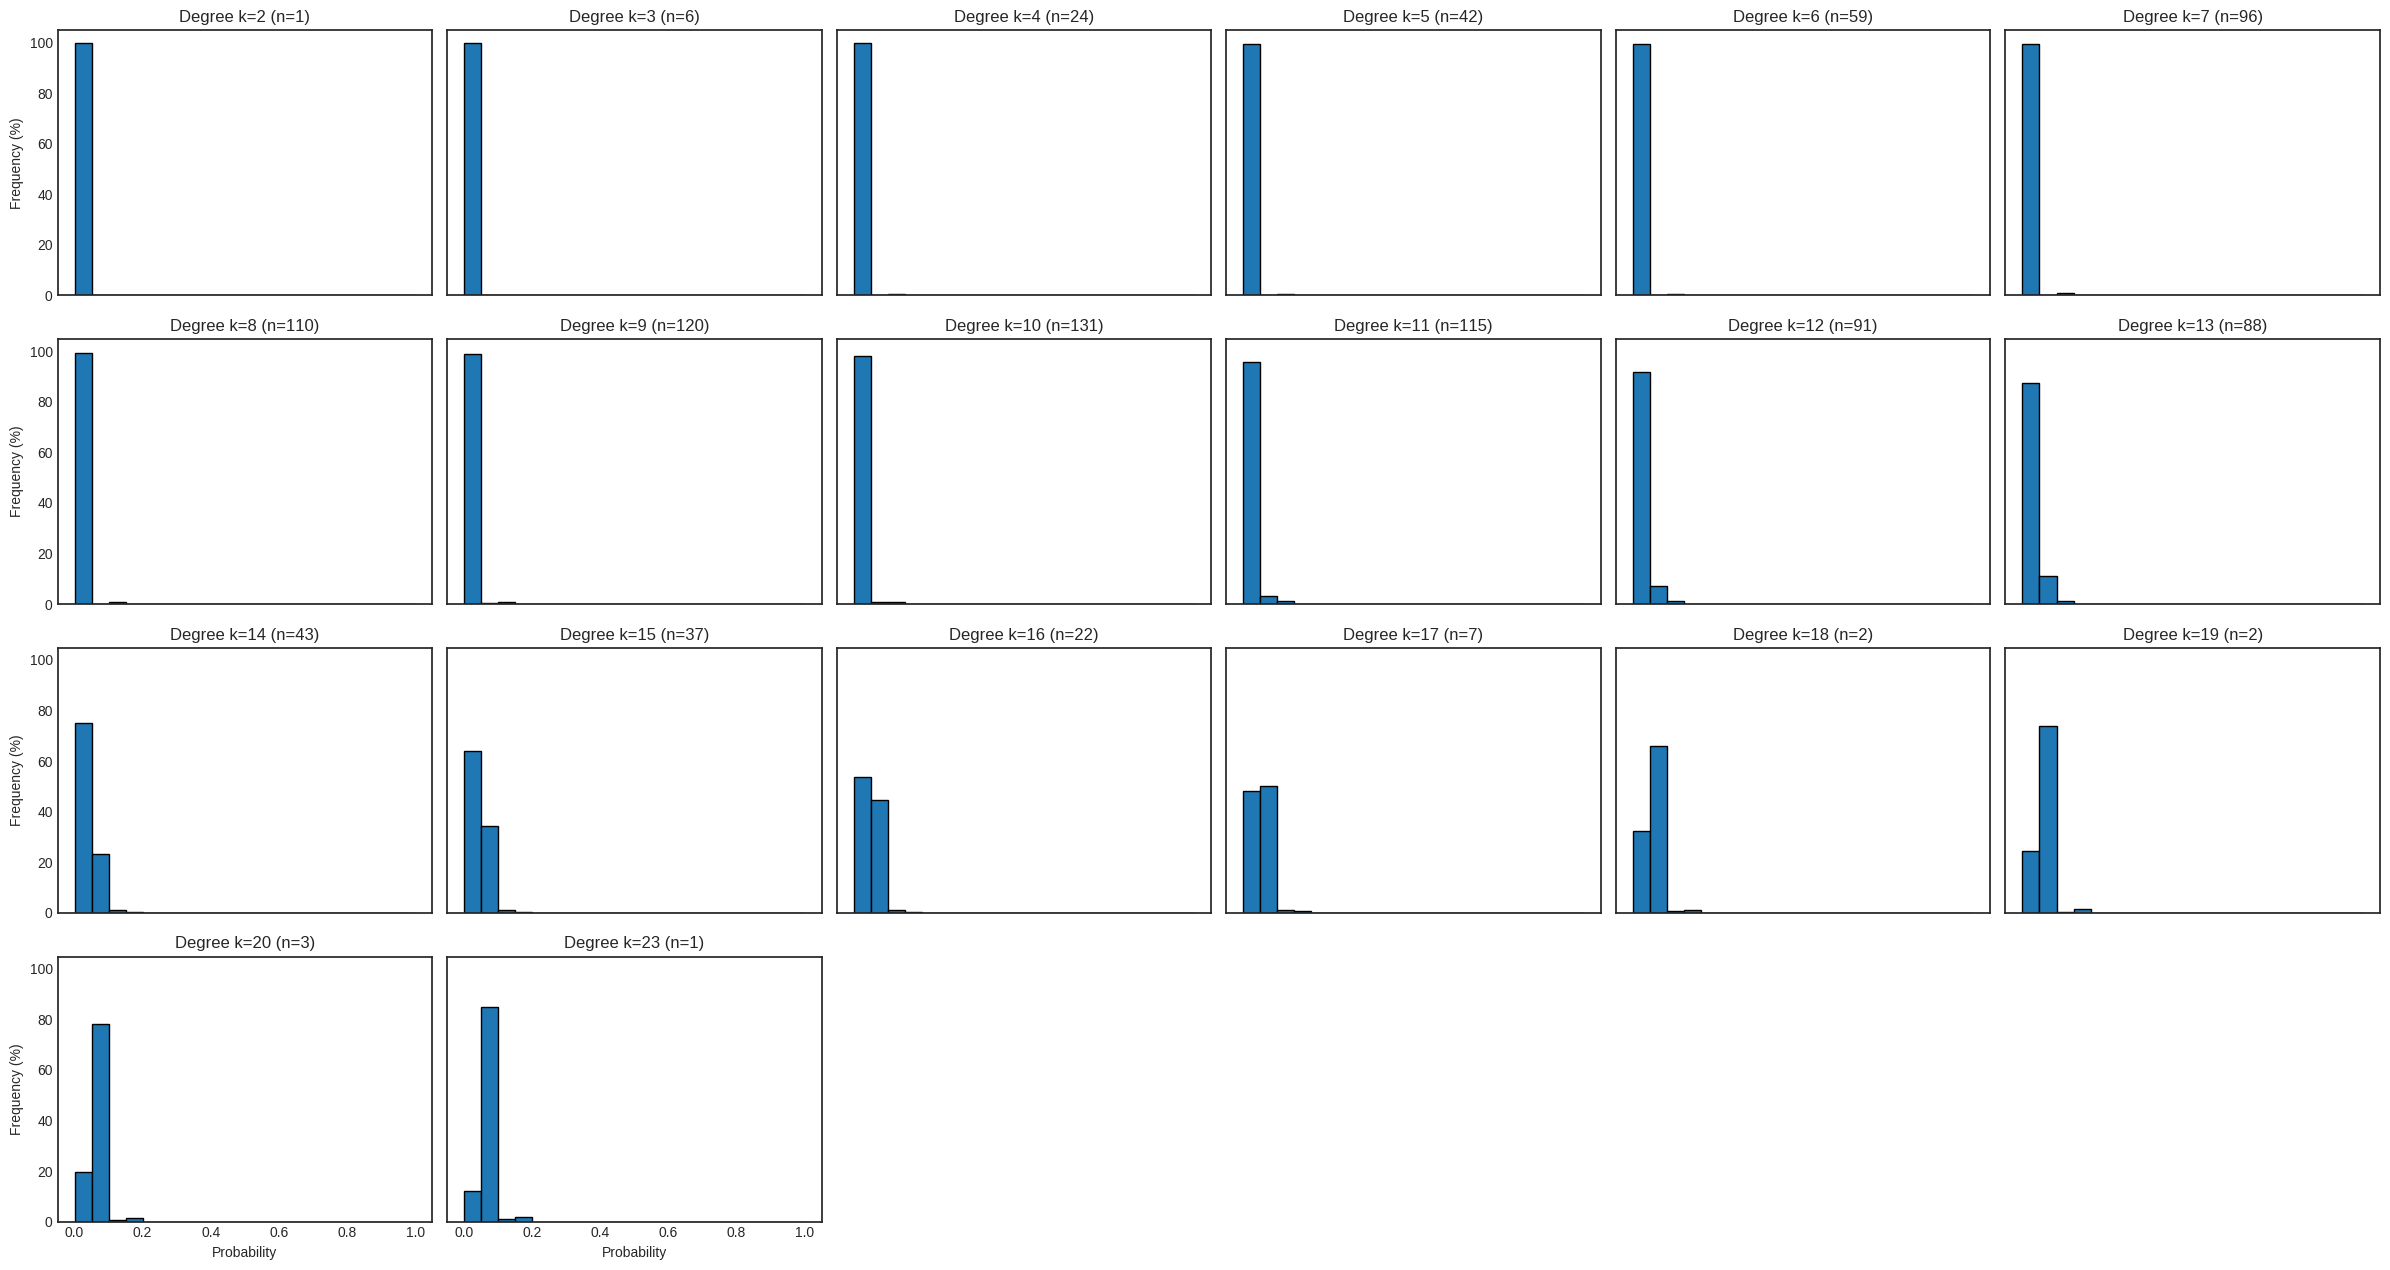

In [ ]:
individual_csv_ER = "/content/drive/My Drive/Individual_Attack_Rate/individual_attack_ER.csv"
neighbors_csv_ER  = "/content/drive/My Drive/Individual_Attack_Rate/graph_neighbors_ER.csv"

plot_prob_histograms_by_degree(
    individual_csv_ER,
    neighbors_csv_ER,
    outname="degree_hist_panels_ER.pdf"
)

Saved PDF to: /content/drive/My Drive/Individual_Attack_Rate/degree_hist_panels_regular.pdf


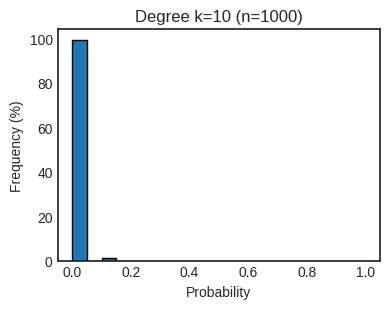

In [ ]:
individual_csv_regular = "/content/drive/My Drive/Individual_Attack_Rate/individual_attack_regular.csv"
neighbors_csv_regular  = "/content/drive/My Drive/Individual_Attack_Rate/graph_neighbors_regular.csv"

plot_prob_histograms_by_degree(
    individual_csv_regular,
    neighbors_csv_regular,
    outname="degree_hist_panels_regular.pdf"
)